In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
from datetime import datetime
import matplotlib.animation as animation
from copy import deepcopy as copy
from src import convert
from IPython.display import display as disp, Math, Latex
import scipy.signal
from src import plot
def print_latex(code):
  """Print a LaTeX string."""
  disp(Math(code))
from numba import njit # optional (on-the-fly compilation)

---

# 1. Introduction

### Initialization

In [2]:

DT = 600 # in seconds
T = 2500 # number of time steps
t = np.arange(T)*DT

### Body class

In [3]:
# Class definition

class Body():
    all = []

    def __init__(self, name, pos, vel, acc, gm, color):
        self.name = name
        self.pos = pos
        self.initial_pos = pos
        self.vel = vel
        self.initial_vel = vel
        self.acc = acc
        self.initial_acc = acc
        self.gm = gm
        self.pos_dyn = np.zeros((T,3))
        self.pos_dyn[0] = self.pos
        self.vel_dyn = np.zeros((T,3))
        self.vel_dyn[0] = self.vel
        self.acc_dyn = np.zeros((T,3))
        self.acc_dyn[0] = self.acc
        self.color = color
        Body.all.append(self)

### Body definition

In [4]:
mimas = Body(
    name = 'Mimas',
    pos  = np.array([-1.813557294137345E+05, 3.492995866271013E+04, 5.054192147215439E+03]),
    vel  = np.array([-2.445920348718876E+00, 1.416736794928916E+01, 1.873213454946043E-02]),
    acc  = np.array([0,0,0]),
    gm   = 2.503489,
    color = "tab:blue")

thetys = Body(
    name = 'Thetys',
    pos  = np.array([-1.889929479196472E+05, -2.260662471700913E+05, -7.020174976279632E+02]),
    vel  = np.array([8.706811449016753E+00, -7.280896606319645E+00, -2.143307520131600E-01]),
    acc  = np.array([0,0,0]),
    gm   = 41.21,
    color = "tab:orange")

titan = Body(
    name = 'Titan',
    pos  = np.array([2.956179324256932E+05, 1.212611254175863E+06, -6.683800852915738E+02]),
    vel  = np.array([-5.322398770209340E+00, 1.190373084298060E+00, -3.847254100240810E-02]),
    acc  = np.array([0,0,0]),
    gm   = 8978.14,
    color = "tab:green")

saturn = Body(
    name = 'Saturn',
    pos  = np.array([0,0,0]),
    vel  = np.array([0,0,0]),
    acc  = np.array([0,0,0]),
    gm   = 37931206.2,
    color = "tab:red")

saturn.R = 60268 # km
saturn.J2 = 1.629e-2

# Initial acceleration
# for body in [mimas, thetys, titan]:
#     body.acc = body.compute_acceleration(saturn)

### Cartesian to orbital elements conversion

In [5]:
def compute_orbital_dyn(bodies=Body.all):
    for body in bodies:
        body.orb_dyn = np.zeros((T,6))
        for t in range(0,T):
            body.orb_dyn[t] = convert.cartesian_to_orbital(body.pos_dyn[t], body.vel_dyn[t], saturn.gm + body.gm)

---

# 2. Integration

We first consider the point mass approximation in the saturn point of view, where the gravitational acceleration is given by

$$\vec{a}_{moon} = -\frac{G M_{saturn} + GM_{moon}}{r^2} \hat{r}$$

where $G$ is the gravitational constant, $M$ is the mass of the central body, $m$ is the mass of the satellite, and $r$ is the distance between the satellite and the central body.

To integrate this function, we can use either a range-kutta method or a leap frog integrator. In the the following code, we used the runge-kutta method because it is more accurate than the leap frog integrator (order 4 instead of 2).

The Runge Kutta algorithm is the following:

$$\begin{align} k_1 &= f(t_n, y_n) \\ k_2 &= f(t_n + \frac{dt}{2}, y_n + \frac{dt}{2} k_1) \\ k_3 &= f(t_n + \frac{dt}{2}, y_n + \frac{dt}{2} k_2) \\ k_4 &= f(t_n + h, y_n + dt k_3) \\ y_{n+1} &= y_n + \frac{dt}{6} (k_1 + 2 k_2 + 2 k_3 + k_4) \end{align}$$

where $dt$ is the time step, $t_n$ is the time at step $n$, $y_n$ is the state (position and velocity) of a given body at step $n$, and $f$ is the function to integrate, which is our definition of $\vec{a}$.

As parameters, we then need to define the initial conditions of the satellite (position and velocity found on the JPL website), the time step and the number of steps. We also need to define the mass of the bodies. All of this was define in the code above, in object creation.

To validate the integration, we can:
- check the total energy of the system, which should be constant.
- check with the two methods if they give the same result.
- compare the position and velocity at a given time with the JPL website. This is the perfect way to validate our integrator, but the real system is actually much more complexe then the one we are designing. We wil lthen stick only to the two first points.

In [6]:
@njit(fastmath=True) # optional (on-the-fly compilation)
def acceleration(r:np.ndarray, gm:float, flattened:bool=False) -> float:
    
    d = np.linalg.norm(r)
    acc = -gm * r / d**3

    if flattened:
        R = 60268 # km
        J2 = 1.629e-2
        flat_acc = np.zeros(3) - 3/2 * gm * J2 * R**2 * r / d**7
        flat_acc[0] *=   r[0]**2 +   r[1]**2 - 4*r[2]**2
        flat_acc[1] *=   r[0]**2 +   r[1]**2 - 4*r[2]**2
        flat_acc[2] *= 3*r[0]**2 + 3*r[1]**2 - 2*r[2]**2
        acc += flat_acc
        
    return acc

### Runge-Kutta integrator

In [7]:
# Acceleration function : f(t,y) -> (v,a)     with y = (p,v)
def acceleration_rk(t, y, body, bodies=[mimas, thetys, titan], perturbated=False, saturn_flattened=False) -> np.array:
    pos = y[:3]
    vel = y[3:]

    # Compute acceleration caused by saturn
    if body is not saturn:
        acc = acceleration(pos, saturn.gm + body.gm, flattened=saturn_flattened)

    # Compute acceleration caused by other bodies
    if perturbated:
        for other_body in bodies:
            if (other_body is body): continue
            acc += acceleration(other_body.pos - pos, other_body.gm)

    return np.concatenate((vel, acc))

# Runge kutta 4th order : rk4(t,dt,y,evaluate) -> y     with y = (p,v)
def rk4(t,dt,y,evaluate, body, bodies=[mimas, thetys, titan], perturbated=False, saturn_flattened=False) -> np.array:

    k1 = evaluate(t, y,                      body=body, bodies=bodies, perturbated=perturbated, saturn_flattened=saturn_flattened)
    k2 = evaluate(t + 0.5*dt, y + 0.5*k1*dt, body=body, bodies=bodies, perturbated=perturbated, saturn_flattened=saturn_flattened)
    k3 = evaluate(t + 0.5*dt, y + 0.5*k2*dt, body=body, bodies=bodies, perturbated=perturbated, saturn_flattened=saturn_flattened)
    k4 = evaluate(t + dt, y + dt*k3,         body=body, bodies=bodies, perturbated=perturbated, saturn_flattened=saturn_flattened)
    
    y_new = y + (1./6.)*(k1+ 2.*k2 + 2.*k3 + k4) * dt

    return y_new

In [8]:

# Evolve using Runge Kutta method
def evolve_rk(bodies=[mimas, thetys, titan], T=T, perturbated=False, saturn_flattened=False):

    for body in bodies:
        body.pos = np.copy(body.initial_pos)
        body.vel = np.copy(body.initial_vel)
        body.acc = np.copy(body.initial_acc)

    for t in range(1,T):    
        for body in bodies:

            y = np.concatenate((body.pos, body.vel))
            y = rk4(t*DT, DT, y, acceleration_rk, body=body, bodies=bodies, perturbated=perturbated, saturn_flattened=saturn_flattened)

            body.pos = y[:3]
            body.vel = y[3:]

            body.pos_dyn[t] = np.copy(body.pos)
            body.vel_dyn[t] = np.copy(body.vel)
            
    compute_orbital_dyn(bodies)

### Leap Frog integrator

In [9]:
def acceleration_lf(body, bodies=[mimas, thetys, titan], perturbated=False, saturn_flattened=False):
    
    # Compute acceleration caused by saturn
    if body is not saturn:
        acc = acceleration(body.pos, saturn.gm + body.gm, flattened=saturn_flattened)

    # Compute acceleration caused by other bodies
    if perturbated:
        for other_body in bodies:
            if (other_body is body): continue
            acc += acceleration(other_body.pos - body.pos, other_body.gm)

    return acc

In [10]:
# Evolve using Leap Frog method
def evolve_lf(bodies=[mimas, thetys, titan], T=T, perturbated=False, saturn_flattened=False):

    for body in bodies:
        body.pos = np.copy(body.initial_pos)
        body.vel = np.copy(body.initial_vel)
        body.acc = np.copy(body.initial_acc)

    for t in range(1,T):
        for body in bodies:
            body.pos = body.pos + body.vel * DT + body.acc/2 * DT**2
            body.vel =            body.vel      + body.acc/2 * DT
            body.acc = acceleration_lf(body, bodies=bodies, perturbated=perturbated, saturn_flattened=saturn_flattened)
            body.vel =            body.vel      + body.acc/2 * DT

            body.pos_dyn[t] = np.copy(body.pos)
            body.vel_dyn[t] = np.copy(body.vel)

    compute_orbital_dyn(bodies)

In [11]:
# Compute evolution
evolve_rk(bodies=[mimas, thetys, titan])

c:\Users\vince\Documents\Dev\CompuPhys\M2-Saturn-moons\src\convert.py:133: RuntimeWarning: invalid value encountered in sqrt
  e = np.sqrt(k*k - h*h)


### Plot position evolution

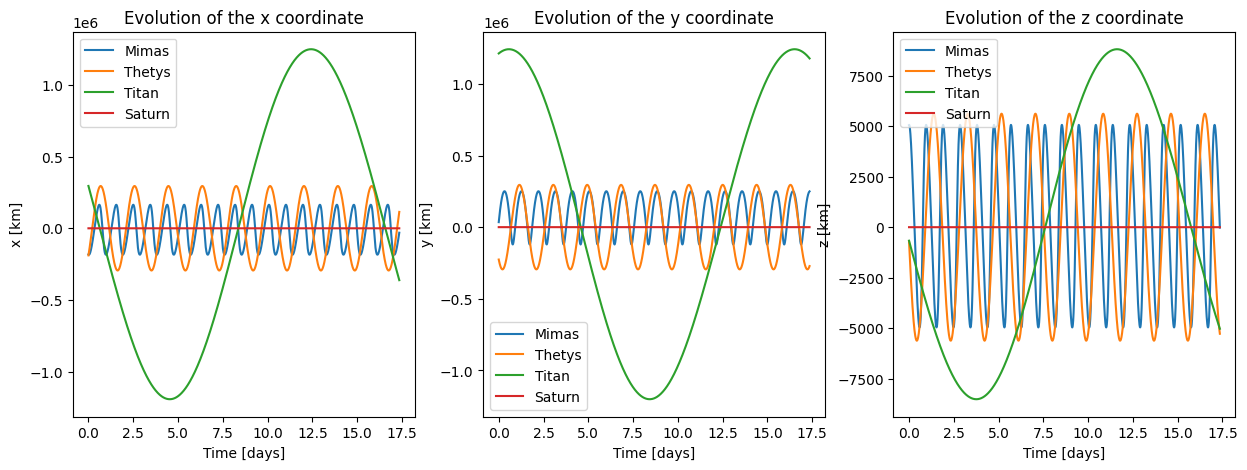

In [12]:
plot.pos_dyn(Body.all, T, DT)

### 3D representation of orbits

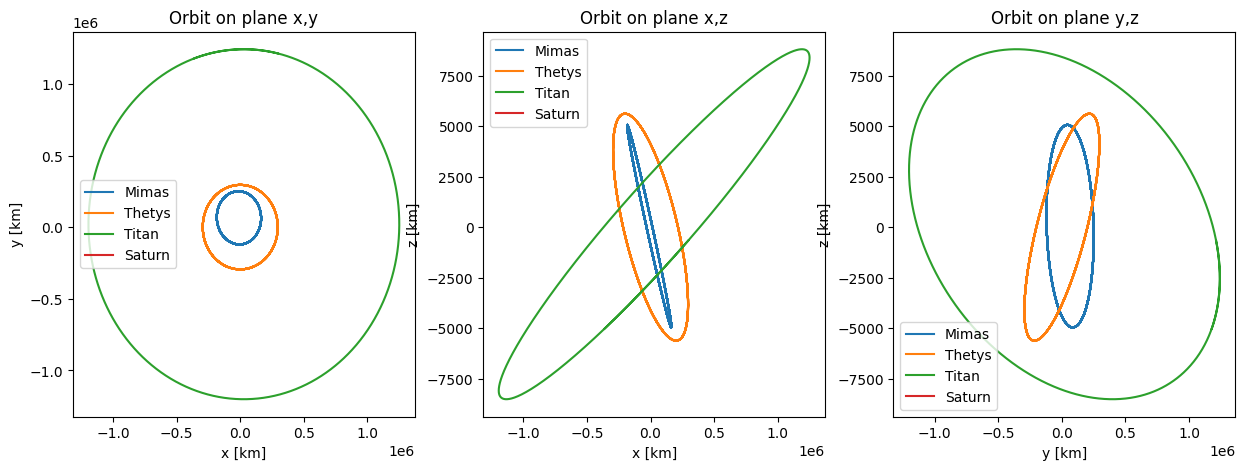

In [13]:
plot.orbits(Body.all)

### Plot velocity evolution

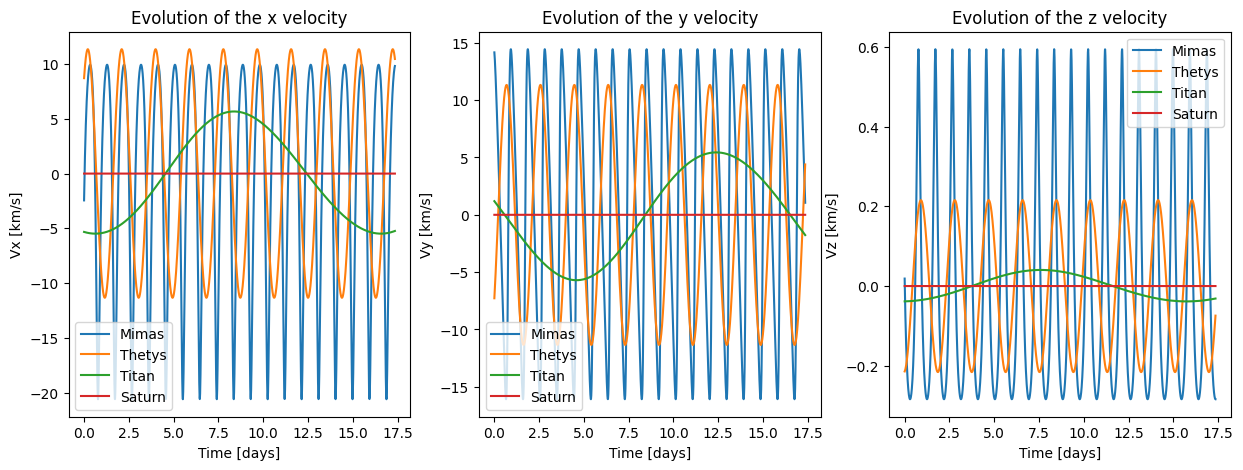

In [14]:
plot.vel_dyn(Body.all, T, DT)

---

# 3. Switching from cartesian to keplerian elements, and conversely

### Convert to orbital elements

In [15]:
def orbital_element_to_string(ell):
    ell = [round(i,3) for i in ell]
    return r"a="+str(ell[0])+r"\quad e="+str(ell[1])+r"\quad i="+str(ell[2])+r"\quad \Omega="+str(ell[3])+r"\quad \varpi="+str(ell[4])+r"\quad \lambda="+str(ell[5])

In [16]:
def print_orbital_elements(bodies=[mimas, thetys, titan]):
    for body in bodies:
        for t in range(0,T):
            if t == 0:
                ell = orbital_element_to_string(body.orb_dyn[t])
                string = r"\text{" + body.name + r"'s initial keplerian elements:\quad}"+ell
            if t == T-1:
                ell = orbital_element_to_string(body.orb_dyn[t])
                print_latex(string + r"\\ \text{" + body.name + r"'s final keplerian elements:\quad}"+ell)

In [17]:
print_orbital_elements([mimas, thetys, titan])

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

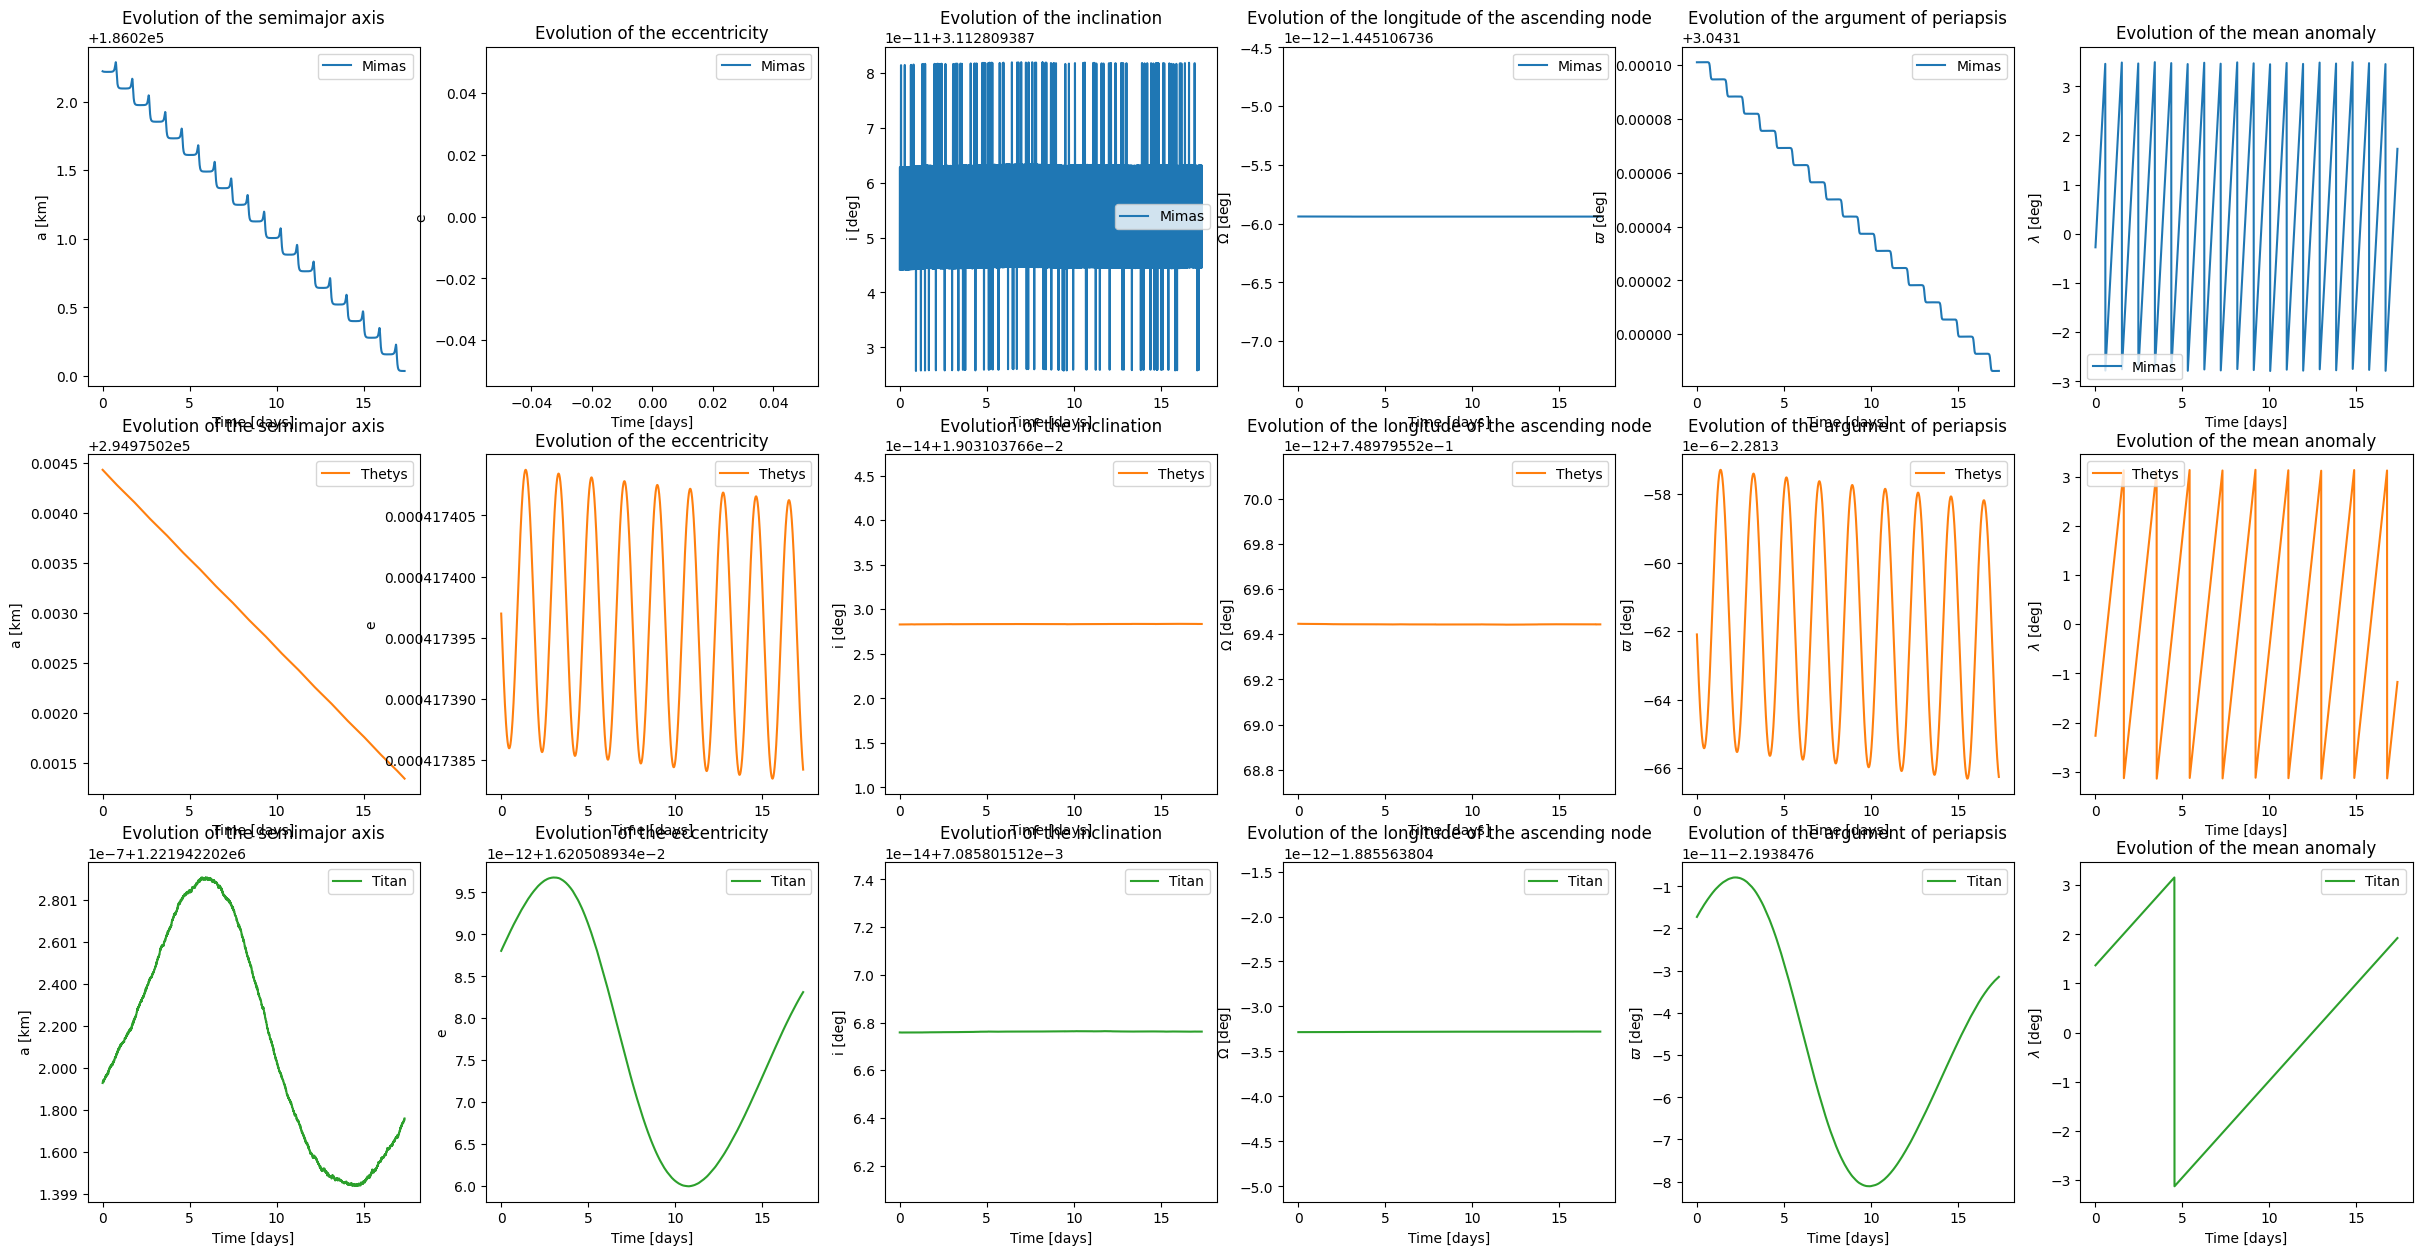

In [18]:
plot.orbital_elements([mimas, thetys, titan], T, DT)

When the system is not perturbated, we see that the orbital elements are conserved.

---

# 4. Including the mutual perturbations

### Adding perturbations

In [19]:
evolve_rk(bodies=[mimas, thetys, titan], perturbated=True)

c:\Users\vince\Documents\Dev\CompuPhys\M2-Saturn-moons\src\convert.py:133: RuntimeWarning: invalid value encountered in sqrt
  e = np.sqrt(k*k - h*h)


### Plot position evolution

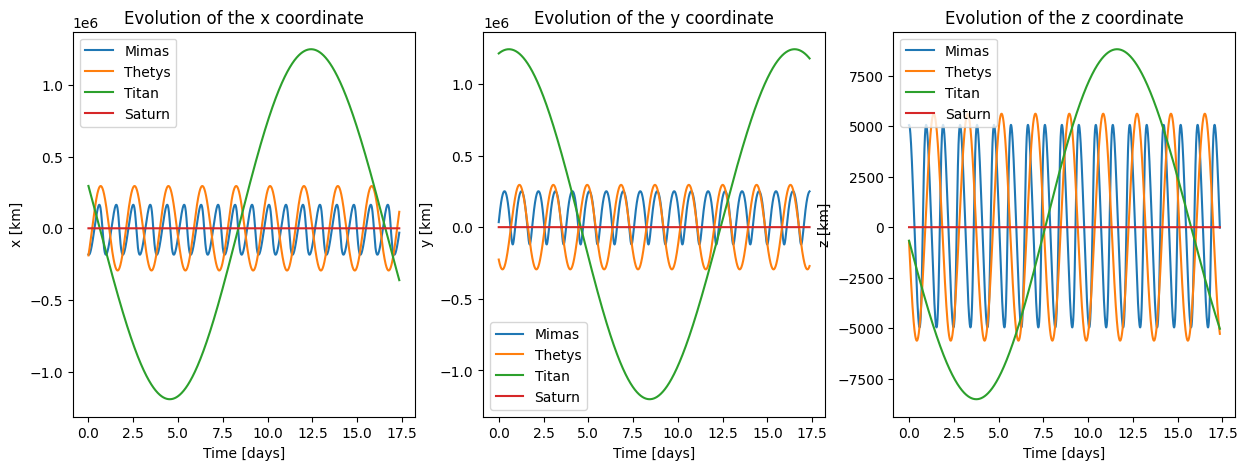

In [20]:
plot.pos_dyn(Body.all, T, DT)

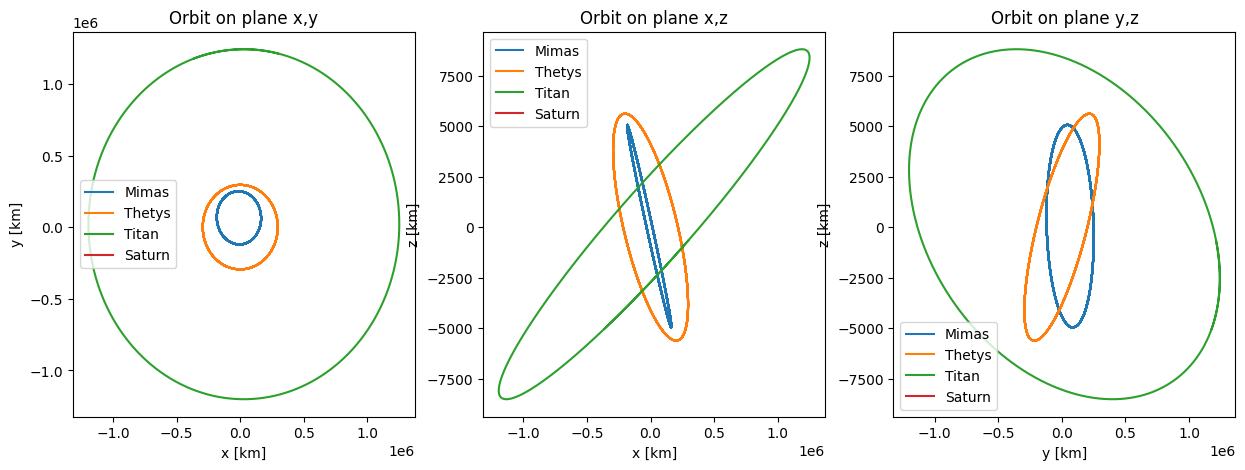

In [21]:
plot.orbits(Body.all)

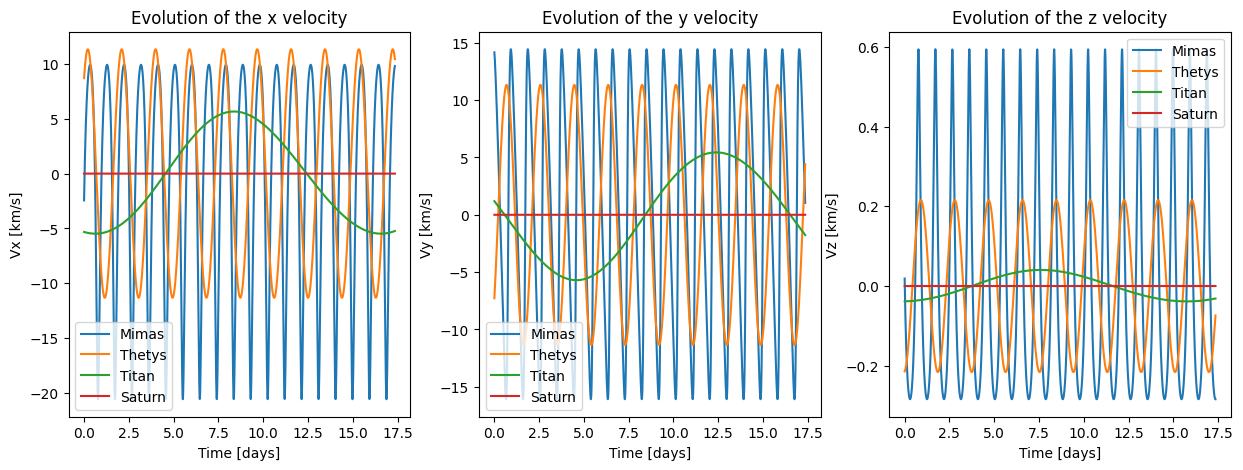

In [22]:
plot.vel_dyn(Body.all, T, DT)

### Orbital elements

In [23]:
print_orbital_elements([mimas, thetys, titan])

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

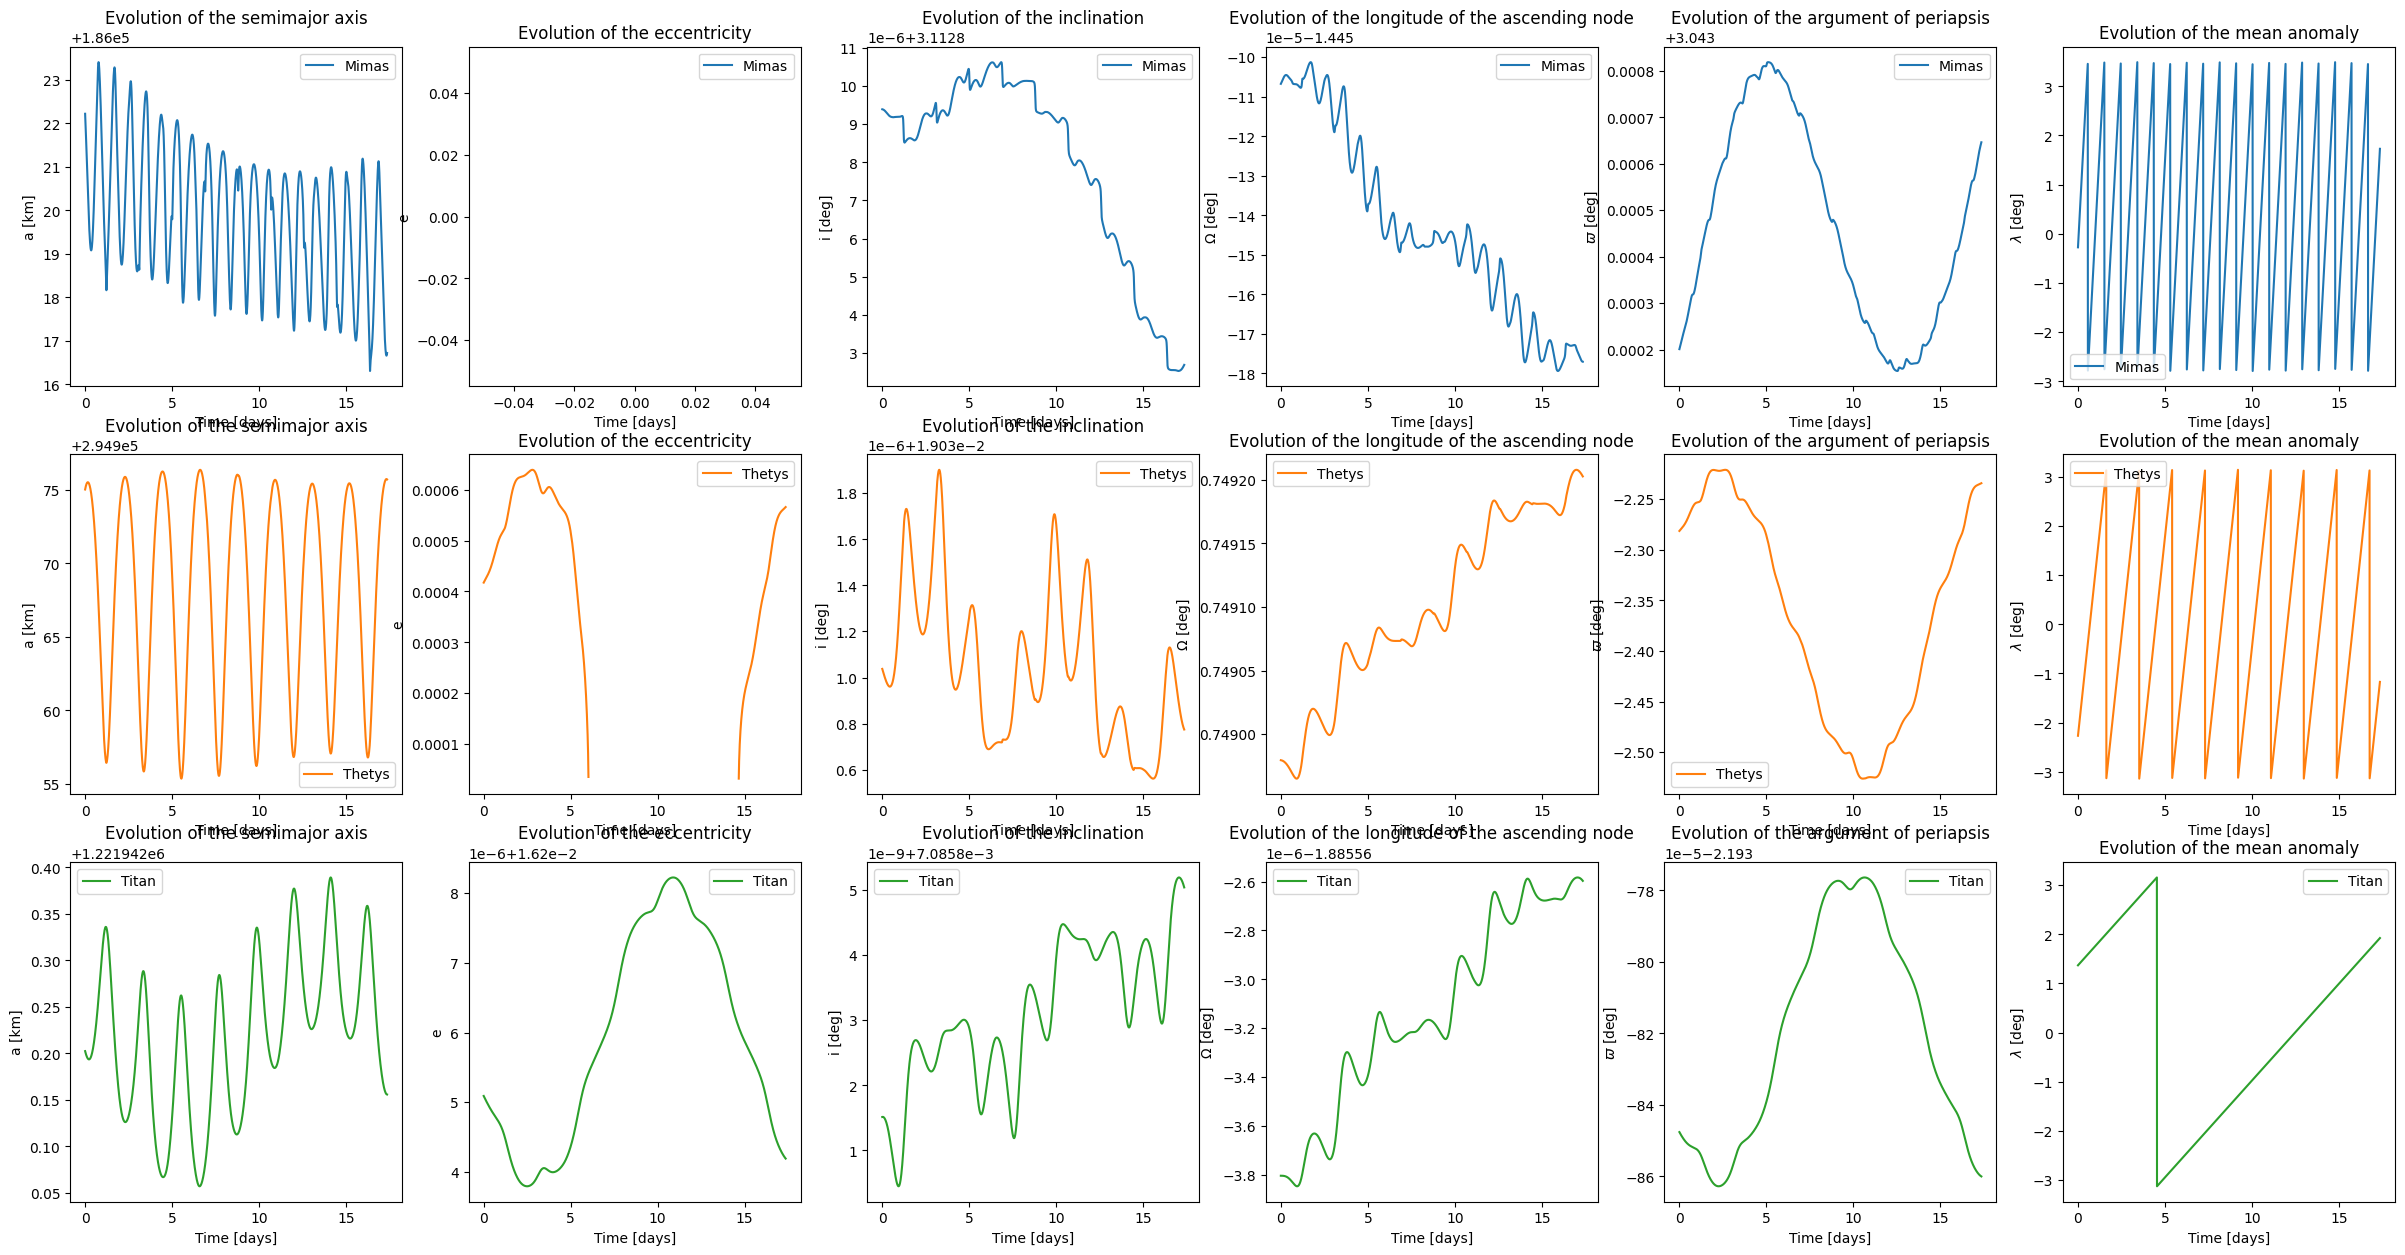

In [24]:
plot.orbital_elements([mimas, thetys, titan], T, DT)

We can see on theses plots that the semi-major axis of Titan is less perturbated than Thetys and Mimas. This is because Titan is the farthest from Saturn, and therefore the gravitational acceleration induced by the two other moons is almost neglectable.

For the other parameters, we cannot really conclude due to a problem of conversion that gives us results that we are not able to confirm, so they can be totally wrong.

---

# 5. The flattening of Saturn

In [25]:
evolve_rk(bodies=[mimas, thetys, titan], perturbated=True, saturn_flattened=True)

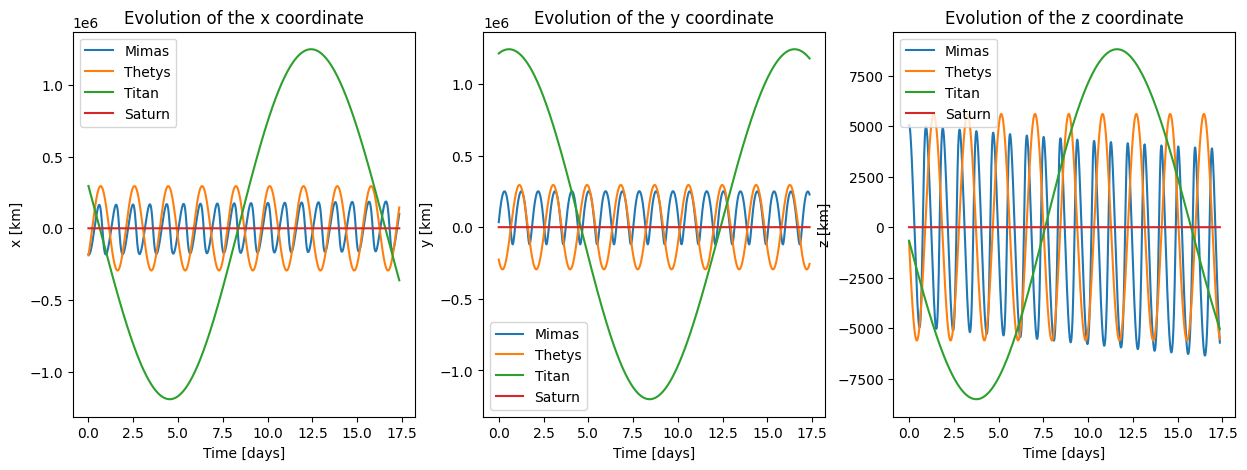

In [26]:
plot.pos_dyn(Body.all, T, DT)

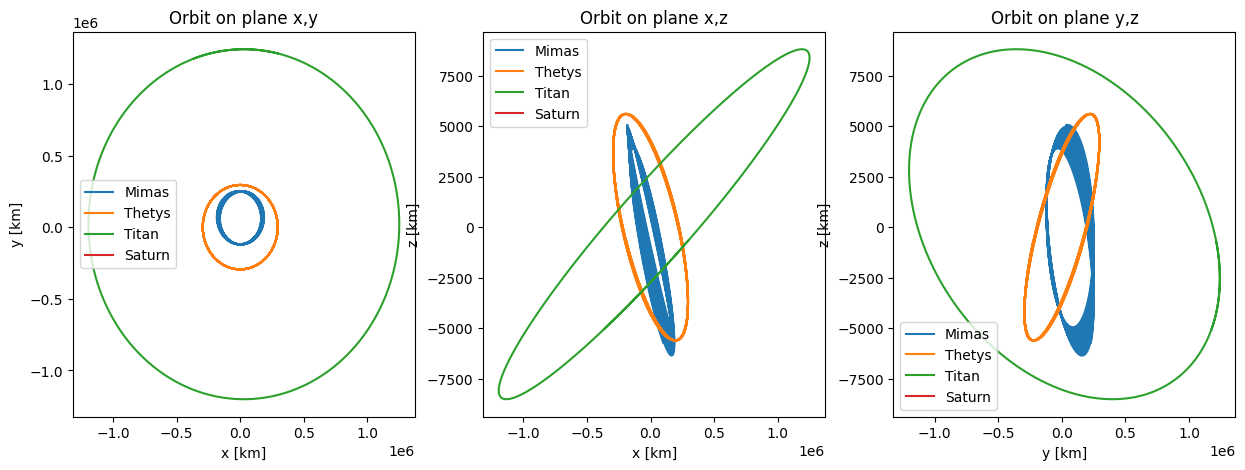

In [27]:
plot.orbits(Body.all)

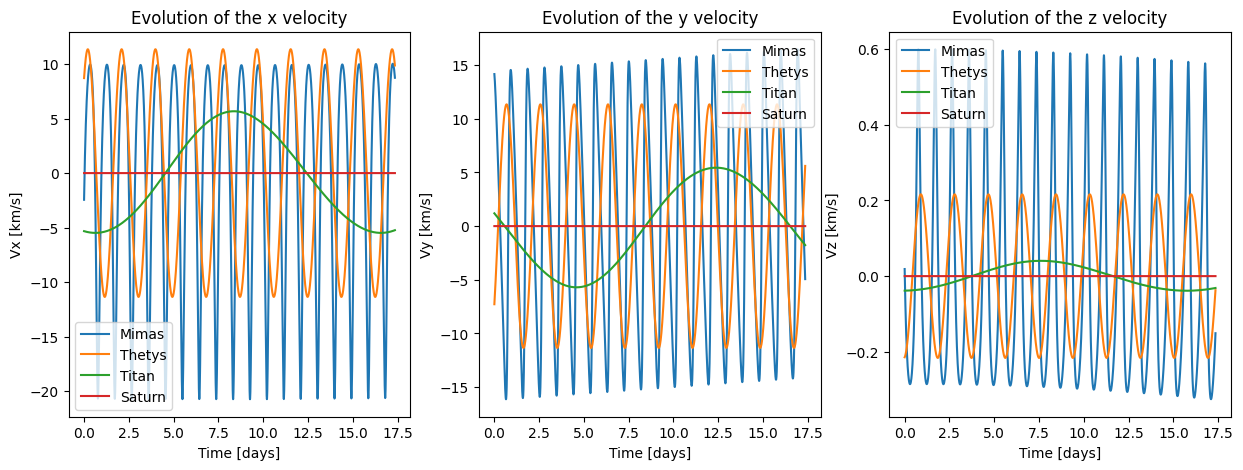

In [28]:
plot.vel_dyn(Body.all, T, DT)

In [29]:
print_orbital_elements([mimas, thetys, titan])

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

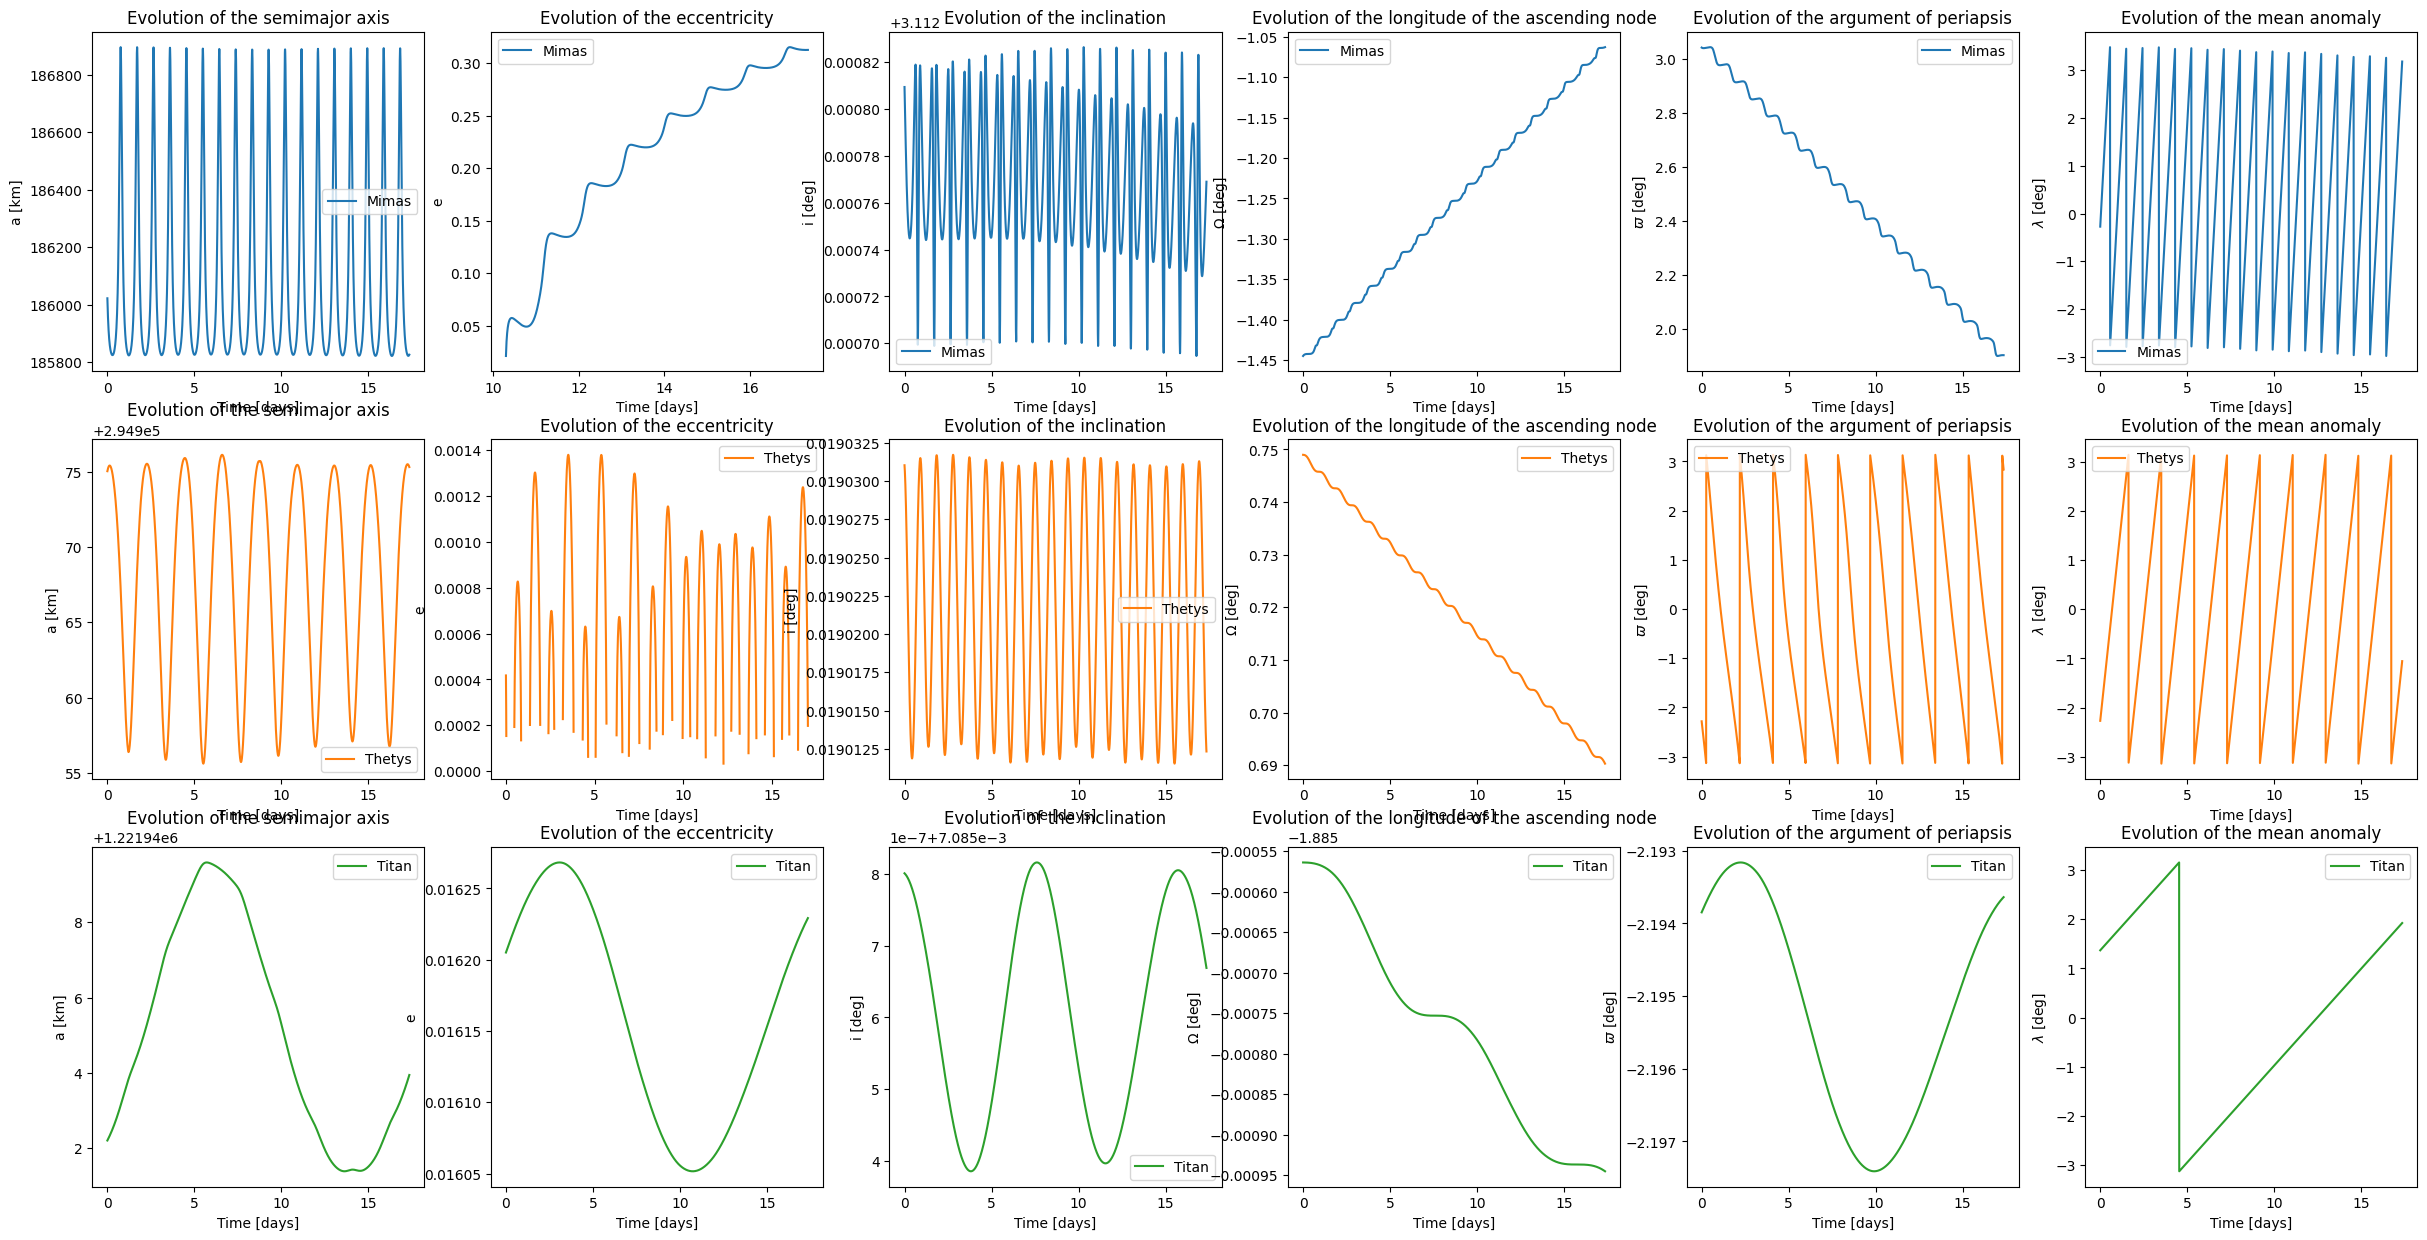

In [30]:
plot.orbital_elements([mimas, thetys, titan], T, DT)

In [31]:
@njit(fastmath=True, parallel=True) # optional (on-the-fly compilation)
def central_diff(f, dt):
    newf = np.zeros(len(f))
    for i in range(1,len(f)-1):
        newf[i] = (f[i+1] - f[i-1]) / (2*dt)
    newf[0] = (f[1] - f[0]) / dt
    newf[-1] = (f[-1] - f[-2]) / dt
    return newf

In [32]:
@njit(parallel=True) # optional (on-the-fly compilation)
def get_period(sig, t):
    maxima = []
    for i in np.arange(len(sig)-2)+1:
        if sig[i-1] < sig[i] > sig[i+1]:
            maxima.append(t[i])
    return (maxima[-1] - maxima[0]) / (len(maxima) - 1)

In [33]:
for body in [mimas, thetys, titan]:
    body.T = get_period(mimas.pos_dyn[:,0], t)
    body.n = 2*np.pi / body.T
    print(body.name, body.T, body.n)

Mimas 81352.94117647059 7.723365887350179e-05
Thetys 81352.94117647059 7.723365887350179e-05
Titan 81352.94117647059 7.723365887350179e-05


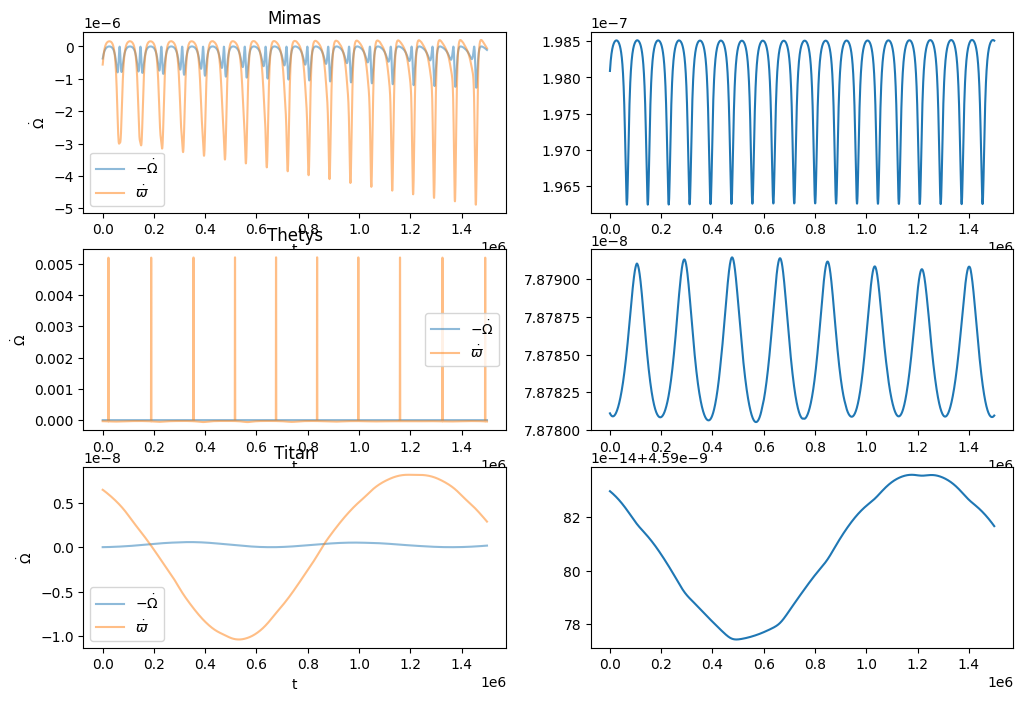

In [34]:
fig, axs = plt.subplots(3, 2, figsize=(12,8))

for i, body in enumerate([mimas, thetys, titan]):
    body.omega_dot_dyn = central_diff(body.orb_dyn[:,3], DT)
    body.varpi_dot_dyn = central_diff(body.orb_dyn[:,4], DT)

    axs[i,0].plot(t, -body.omega_dot_dyn, label=r"$-\dot{\Omega}$", alpha=0.5)
    axs[i,0].plot(t, body.varpi_dot_dyn, label=r"$\dot{\varpi}$", alpha=0.5)
    axs[i,1].plot(t, 3/2*saturn.J2 * body.n * (saturn.R / body.orb_dyn[:,0])**2, label=r"$\frac{3}{2}J_2 n \left(\frac{R}{a}\right)^2$")
    axs[i,0].set_title(body.name)
    axs[i,0].set_xlabel("t")
    axs[i,0].set_ylabel(r"$\dot{\Omega}$")
    axs[i,0].legend()

plt.show()
    
    

If we want to get these relations, we use the Lagrange perturbation equations:

- For the semi-major axis a :
$$\frac{da}{dt} = \frac{2}{n} * \frac{a^2}{h} * \frac{J2 * R^2}{a^2} * (1 - \frac{3}{2} * sin^2(i))$$

- For the eccentricity e : 
$$\frac{de}{dt} = \frac{2}{n} * \frac{a}{h} * \frac{J2 * R^2}{a^2} * (1 - \frac{3}{2} * sin^2(i)) * cos(varpi)$$

- For the inclination i :
$$\frac{di}{dt} = -\frac{3}{n} * \frac{J2 * R^2}{a^2} * sin(i) * cos(i)$$

- For the longitude of the ascending node Omega :
$$\frac{d\Omega}{dt} = \frac{3}{n} * \frac{J2 * R^2}{a^2} * cos(i)$$

- For the argument of periapsis varpi :
$$\frac{d\varpi}{dt} = \frac{3}{n} * \frac{J2 * R^2}{a^2} * (n + sin(i) * (cos(\Omega) * cos(\varpi) - sin(\Omega) * sin(\varpi)))$$

- For the mean anomaly lambda :
$$\frac{d\lambda}{dt} = n + \frac{3}{2} * \frac{J2 * R^2}{a^2} * (n + sin(i) * (cos(\Omega) * cos(\varpi) - sin(\Omega) * sin(\varpi)))$$

Here, the ones that interest us are the ascending node and the argument of the periapsis.

Considering that the variation of inclination $i$ and the longitude of the ascending node $\Omega$ are very small, and assuming that $\varpi_0$ is very close to 0, we can simplify the previous equation to obtain:

$$-\frac{d\Omega}{dt} = \frac{3}{2} J_2 n \left(\frac{R}{a}\right)^2$$
$$\frac{d\varpi}{dt} = \frac{3}{2} J_2 n \left(\frac{R}{a}\right)^2$$

> Or... we can ask chatGPT to do it for us... and that's what it does above!
> 
> *sorry, we couldn't resist, but actually we don't have time for this anymore, we spent to much to try to find the problem in the cartesian to orbital elements function :/*

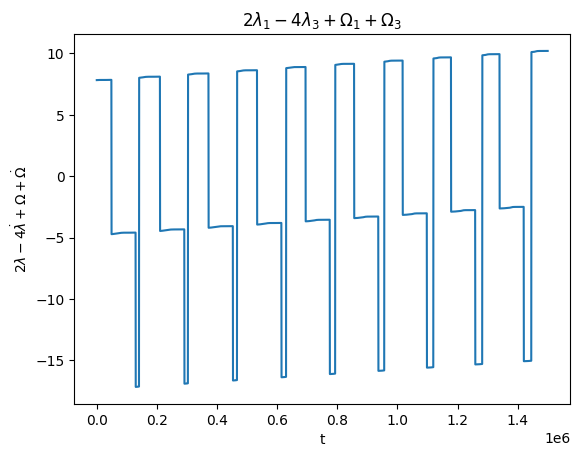

In [35]:
somme_chelou = 2*mimas.orb_dyn[:,5] - 4*thetys.orb_dyn[:,5] + mimas.orb_dyn[:,3] + thetys.orb_dyn[:,3]
plt.plot(t, somme_chelou)
plt.title(r"$2\lambda_1 - 4\lambda_3 + \Omega_1 + \Omega_3$")
plt.xlabel("t")
plt.ylabel(r"$2\lambda - 4\dot{\lambda} + \Omega + \dot{\Omega}$")
plt.show()


> It's nice but as $\Omega$ is one of the orbital elements that are wrongly computed, this graph is probably false.